In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, FFMpegWriter
%matplotlib inline
from IPython.display import HTML, Image

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('GnBu', 8)

################### Hier setzt ihr die Anfangsbestimmungen ###############################

L1 = 1 # Länge von Arm 1
L2 = 1 # Länge von Arm 2
m1 = 2 # Masse von Gewicht 1
m2 = 1 # Masse von Gewicht 2
g = 9.81 #Gravitationskonstante

tmax = 10 # Wie lang soll eure Simulation sein?
w1 = 180 # Auslenkung erstes Pendel in Grad
w2 = 10 # Auslenkung zweites Pendel in Grad

In [3]:
# Hier wird bloß was definiert
def deriv(y, t, L1, L2, m1, m2):
    """
    Return first derivatives of y = theta1, theta1dot, theta2, theta3dot
    """
    theta1, theta1dot, theta2, theta2dot = y
    c1 = np.cos(theta1)
    s1 = np.sin(theta1)
    c2 = np.cos(theta2)
    s2 = np.sin(theta2)    
    c12 = np.cos(theta1-theta2)
    s12 = np.sin(theta1-theta2)
    theta1dotdot = (m2*g*s2*c12 - m2*s12*(L1*theta1dot**2*c12 + L2*theta2dot**2) - (m1+m2)*g*s1) / L1 / (m1 + m2*s12**2)
    theta2dotdot = ((m1+m2)*(L1*theta1dot**2*s12 - g*s2 + g*s1*c12) + m2*L2*theta2dot**2*s12*c12) / L2 / (m1 + m2*s12**2)
    return theta1dot, theta1dotdot, theta2dot, theta2dotdot

# Bestimmt Zeitschritte, für die die Lösung zu diesem Zeitpunkt bestimmt werden sollen
dt = 0.02
t = np.arange(0, tmax+dt, dt) 

# Anfangsbestimmungen werden definiert durch die Winkel Theta1 und Theta2, sowie deren Ableitungen.
y0 = np.array([w1 * np.pi / 180, 0, w2 * np.pi / 180, 0])

# Hier werden dann tatsächlich die Lösungen bestimmt!
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))

# Jetzt wird ausgerechnet, wie viel Energie zu jedem Zeitpunkt im simulierten System ist
def V(y):
    '''Returns potential energy'''
    th1, th1d, th2, th2d = y.T
    return -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
    
def T(y):
    """Returns kinematical energy"""
    th1, th1d, th2, th2d = y.T
    return 0.5*m1*(L1*th1d)**2 + 0.5*m2*((L1*th1d)**2 + (L2*th2d)**2 + 2*L1*L2*th1d*th2d*np.cos(th1-th2))

def E(y):
    '''Total energy of the system'''
    return T(y) + V(y)

# Gesamtenergie ganz am Anfang
E0 = E(y0)

# Abweichungen von der Gesamtenergie ganz am Anfang
dE = np.abs(E(y)-E0)
dEmax = np.max(dE)
print("Die Energie des Anfangszustandes ist %.3f Energieeinheiten. \n" % (E0))
print("Diese Energie sollte eigentlich wegen des Energieerhaltungssatzes eigentlich immer erhalten bleiben! \n")
print("Die größte Abweichung während der Simulation ist %.10f Energieeinheiten. \n" % (dEmax))
print("Je geringer die Abweichung, desto besser die Simulation! ")

Die Energie des Anfangszustandes ist 19.769 Energieeinheiten. 

Diese Energie sollte eigentlich wegen des Energieerhaltungssatzes eigentlich immer erhalten bleiben! 

Die größte Abweichung während der Simulation ist 0.0000314555 Energieeinheiten. 

Je geringer die Abweichung, desto besser die Simulation! 


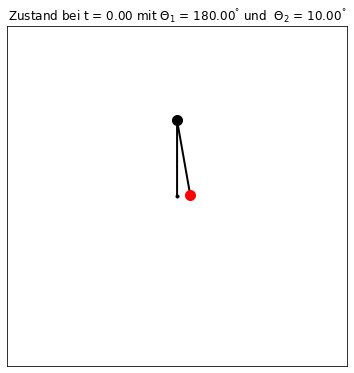

In [4]:
# Hier wird geplottet!
theta1, theta2 = y[:,0], y[:,2]

# Berechne die kartesischen Koordinaten aus den Winkeln und Längen die wir oben definiert haben
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Zeichne uns mal den ersten Punkt
i = 0

r = 0.25
ns = 20
trail_secs = 1
    
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

c0 = ax.plot(0,0,'o',markersize=3,color='black') # Aufhängpunkt

ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # Pendelarme

c1 = ax.plot(x1[i],y1[i],'o',markersize=10,color='black') # sich bewegende Massen
c2 = ax.plot(x2[i],y2[i],'o',markersize=10,color='red')

# Zeichne eine Linie hinter der roten Kugel als "Schweif"
s = int(trail_secs / dt) // ns
for j in range(ns):
    imin = i - (ns-j)*s
    if imin < 0: continue
    imax = imin + s + 1
    alpha = (j/ns)**2
    ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',lw=2, alpha=alpha)
    
ax.set_xlim(-L1-L2-r, L1+L2+r)
ax.set_ylim(-L1-L2-r, L1+L2+r)
ax.set_aspect('equal', adjustable='box')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.title('Zustand bei t = %.2f mit $\Theta_1$ = %.2f$^°$ und  $\Theta_2$ = %.2f$^°$' %(i * dt, w1, w2))
plt.show()

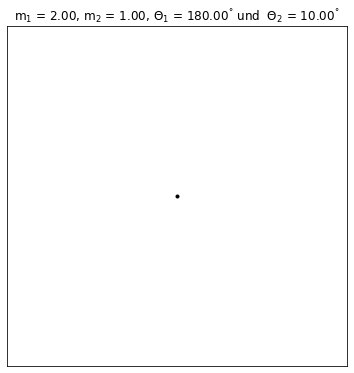

In [5]:
# Und jetzt machen wir ein Video davon!
# Erstmal alles vorbereiten...

def pendolum_init():
    lines.set_data([], [])
    return (lines,)

def pendolum_animate(i):
    lines.set_data([0,x1[i],x2[i]],[0,y1[i],y2[i]])
    c1.set_data([x1[i]],[y1[i]])
    c2.set_data([x2[i]],[y2[i]])
    s = int(trail_secs / dt) // ns
    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        trail[j].set_data(x2[imin:imax],y2[imin:imax])
        tstr = ("%.2f" %(i*dt))
        time_text.set_text("time = " + tstr)
    return (lines,)

i = 50

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

# hanging point
c0 = ax.plot(0,0,'o',markersize=3,color='black')

# pendolum arms
lines, = ax.plot([], [], lw=2, c='k')

# moving masses
c1, = ax.plot([],[],'o',markersize=10,color='black')
c2, = ax.plot([],[],'o',markersize=10,color='red')

# m2 trail
s = int(trail_secs / dt) // ns
trail = []
for j in range(ns):
    imin = i - (ns-j)*s
    if imin < 0: 
        continue
    imax = imin + s + 1
    alpha = (j/ns)**2
    trail_j, = ax.plot([],[], c='r', solid_capstyle='butt',lw=2, alpha=alpha)
    trail.append(trail_j)

ax.set_xlim(-L1-L2-r, L1+L2+r)
ax.set_ylim(-L1-L2-r, L1+L2+r)
ax.set_aspect('equal', adjustable='box')
#plt.axis('off')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
time_text = plt.text(0.9,0.1,"",transform = ax.transAxes, ha="right")
plt.title('m$_1$ = %.2f, m$_2$ = %.2f, $\Theta_1$ = %.2f$^°$ und  $\Theta_2$ = %.2f$^°$' %(m1, m2, w1, w2))
plt.show()

anim = FuncAnimation(fig,pendolum_animate,frames=range(len(x1)),init_func=pendolum_init,blit=True)

In [6]:
# Und hier entsteht dann das Video!
HTML(anim.to_html5_video())

In [64]:
#Falls ihr das Gif speichern wollt:
anim.save('Doppelpendel.gif', writer=FFMpegWriter(fps=15))

250.0
247


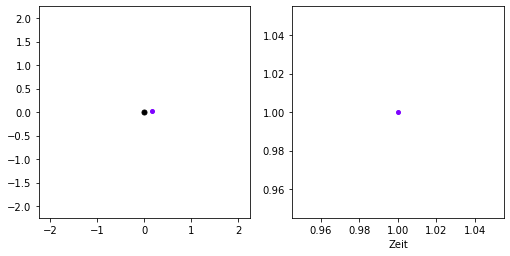

247


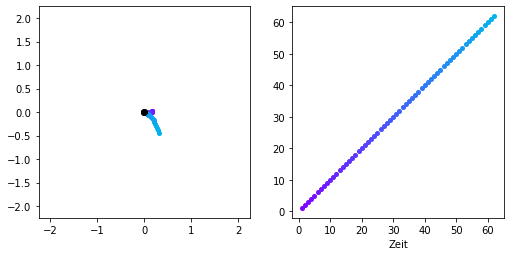

247


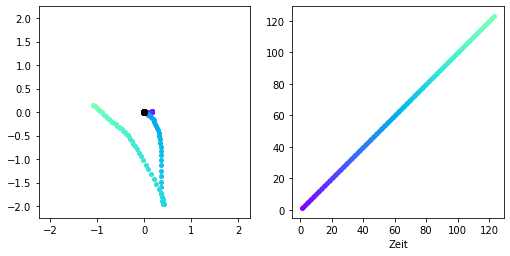

247


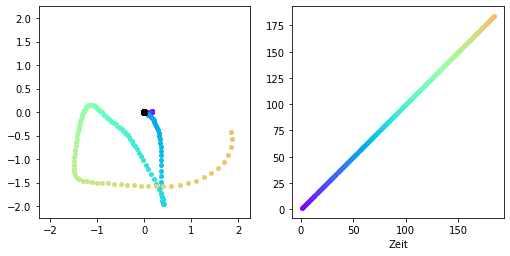

247


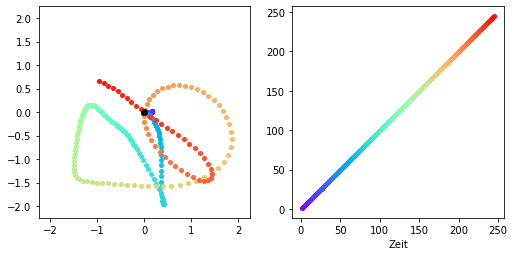

In [10]:
######## Jetzt machen wir "Bilder mit langer Belichtungszeit" #######################

def ShowDynamics(N):
    fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for k in range(1,N):
        
        i = k
        #print(k)
        r = 0.25
        ns = 20
        trail_secs = 1

        c2 = ax.plot(x2[i],y2[i],'o',markersize=4,color=cmap(np.int(k/Npoints*256)))
        c0 = ax.plot(0,0,'o',markersize=5,color='black')

        ax.set_xlim(-L1-L2-r, L1+L2+r)
        ax.set_ylim(-L1-L2-r, L1+L2+r)
        ax.set_aspect('equal', adjustable='box')

        ax2.plot(k,k,'o',markersize=4,color=cmap(np.int(k/Npoints*256)))
        ax2.set_aspect('equal', adjustable='box')
        plt.xlabel('Zeit')


    plt.show()
    return 

Nstep = tmax/dt

cmap = cm.get_cmap(name='rainbow')
#cmap = cm.get_cmap(name='prism')


Npoints = Nstep/2
print(Npoints)
if Npoints>Nstep:
    Npoints = np.int(Nstep)
Npoints = np.int(Npoints)  

# Wie viele Belichtungszeiten wollt ihr ausprobieren?
Nfigs = 4

StepSize = np.int((Npoints-3)/(Nfigs))

col = viridis(range(Npoints))
for N in range(2,Npoints,StepSize):
    print(np.int(Npoints-3))
    ShowDynamics(N)
